In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#importing libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import librosa
import seaborn as sns

In [3]:
path = 'clean'  #Using the clean folder
fpath=[]
labels=[]
for dir_,_,files in os.walk(path):
    for file in files:
        fpath.append(os.path.join(dir_, file))
        labels.append(file.lower().split('_')[-1].split('.')[0])
df = pd.DataFrame()
df['fpath'] = fpath
df['labels'] = labels
df.sample(5)

,fpath,labels
1211,clean\OAF_time_disgust.wav,disgust
671,clean\OAF_make_angry.wav,angry
869,clean\OAF_pike_fear.wav,fear
394,clean\OAF_hash_happy.wav,happy
942,clean\OAF_read_ps.wav,ps


In [4]:
def feature_extract(file):
    audio, rate = librosa.load(file)
    mfcc_feats = librosa.feature.mfcc(y=audio, sr=rate, n_mfcc=40)
    mfcc_scaled = np.mean(mfcc_feats.T, axis=0)
    
    return mfcc_scaled

In [5]:
#extracting mfcc features
mfccs=[]
for idx, rows in tqdm(df.iterrows()):
    filename = df.iloc[idx].fpath
    label = df.iloc[idx].labels
    #print(filename)
    #print(label)
    data = feature_extract(filename)
    mfccs.append([data,label])
    #print(mfccs)

2800it [01:01, 45.42it/s]


In [6]:
features_df = pd.DataFrame(mfccs, columns=['mfcc','labels'])
features_df.sample(5)


,mfcc,labels
645,"[-407.33115, 91.63981, -16.695656, 14.78633, -...",fear
178,"[-482.32407, 123.0588, -18.048435, 23.314825, ...",neutral
1628,"[-395.24225, 95.710434, -49.039642, 67.14218, ...",neutral
1494,"[-308.48703, 78.26816, -46.427845, 32.714462, ...",happy
1609,"[-407.00244, 102.50896, 9.895501, 68.487404, -...",sad


In [7]:
X = np.array(features_df['mfcc'].tolist())
y = np.array(features_df['labels'].tolist())

print(X.shape, y.shape)

(2800, 40) (2800,)


## Random Forest Classifier

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

In [9]:
sc = StandardScaler()
#run these once
X = sc.fit_transform(X)
y = np.array(pd.get_dummies(y))
print(X)
print(y)
print(X.shape, y.shape)

[[ 0.7819702  -0.93222225 -1.0409088  ...  0.18522169 -0.5698652
  -1.1905504 ]
 [-0.9624325   1.959667    0.3005324  ... -0.5229701   0.10252625
   0.5276702 ]
 [ 0.19687809  0.30172706 -0.5116523  ... -0.95769924 -1.1268499
  -0.9163549 ]
 ...
 [-0.05789817  0.5628348  -0.47229567 ... -1.1302434  -1.4368858
  -0.5203722 ]
 [ 0.5349015  -0.47997224 -0.91495067 ... -0.49051097 -0.37220693
  -0.6186865 ]
 [-0.20489812 -0.2626568   1.433742   ... -0.3163493  -0.04934008
   0.08863607]]
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
(2800, 40) (2800, 7)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape)

(1960, 40)


In [11]:
rf_model = RandomForestClassifier(n_estimators=3,max_depth=5,n_jobs=5)
rf_model.fit(X_train,y_train)

RandomForestClassifier(max_depth=5, n_estimators=3, n_jobs=5)

In [12]:
print('Test Accuracy:',rf_model.score(X_test,y_test))

Test Accuracy: 0.6095238095238096


Test Accuracy: 0.6095238095238096


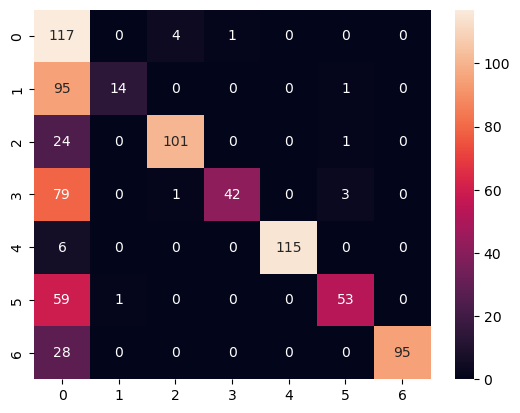

In [13]:
y_hat = rf_model.predict(X_test)
y_pred = [np.argmax(y) for y in y_hat]
y_true = [np.argmax(y) for y in y_test]
cm = confusion_matrix(y_true,y_pred)
sns.heatmap(cm, annot=True,fmt='g')
print('Test Accuracy:',rf_model.score(X_test,y_test))

In [14]:
#using gridsearch to get best params
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 100, num = 10)]
max_features = ['auto','sqrt']
max_depth = [4,8,16,20]
bootstrap = [True, False]

param_grid = {'n_estimators':n_estimators,
              
              'max_depth':max_depth,
              
             }
rf_grid = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5 , verbose=2, n_jobs=4)

In [15]:
%%time
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Wall time: 28.6 s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=5, n_estimators=3,
                                              n_jobs=5),
             n_jobs=4,
             param_grid={'max_depth': [4, 8, 16, 20],
                         'n_estimators': [5, 15, 26, 36, 47, 57, 68, 78, 89,
                                          100]},
             verbose=2)

In [16]:
rf_grid.best_params_

{'max_depth': 16, 'n_estimators': 78}

In [17]:
print(f'Test Accuracy: {rf_grid.score(X_test, y_test):.3f}')

Test Accuracy: 0.981


In [18]:
len(rf_grid.cv_results_['mean_test_score'])

40

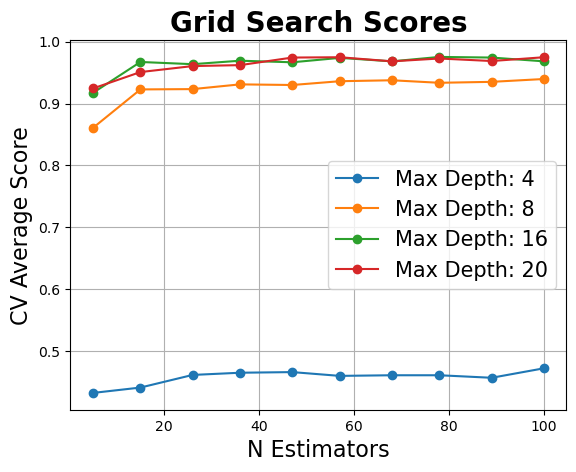

In [19]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

# Calling Method 
plot_grid_search(rf_grid.cv_results_, n_estimators, max_depth, 'N Estimators', 'Max Depth')

In [20]:
#Classification Report
rf_yhat=rf_grid.predict(X_test)
rf_y_pred = [np.argmax(y) for y in rf_yhat]
rf_report = classification_report(y_true,rf_y_pred)
print('=====================Random Forest=====================')
print(rf_report)

=====================Random Forest=====================
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       122
           1       1.00      0.99      1.00       110
           2       1.00      1.00      1.00       126
           3       1.00      0.96      0.98       125
           4       1.00      0.99      1.00       121
           5       0.99      0.96      0.97       113
           6       1.00      0.98      0.99       123

    accuracy                           0.98       840
   macro avg       0.98      0.98      0.98       840
weighted avg       0.98      0.98      0.98       840



<AxesSubplot: >

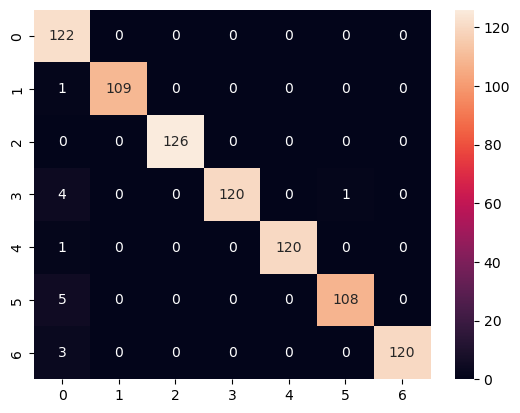

In [21]:
cm = confusion_matrix(y_true,rf_y_pred)
sns.heatmap(cm, annot=True,fmt='g')

## Support Vector Machine

In [33]:
from sklearn.svm import SVC

In [34]:
svm_model = SVC(C=10)
svm_model.fit(X_train, np.argmax(y_train, axis=1))

SVC(C=10)

In [49]:
print('Test Accuracy:',svm_model.score(X_test, np.argmax(y_test, axis=1)))

Test Accuracy: 0.9988095238095238


Test Accuracy: 0.9988095238095238


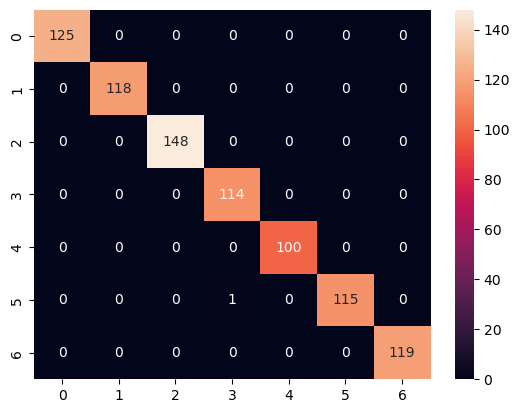

In [70]:
svm_yhat=svm_model.predict(X_test)
y_true = [np.argmax(y) for y in y_test]
cm = confusion_matrix(y_true,svm_yhat)
sns.heatmap(cm, annot=True,fmt='g')
print('Test Accuracy:',svm_model.score(X_test, np.argmax(y_test, axis=1)))

In [105]:
#Classification Report
svm_report = classification_report(y_true,svm_yhat)
print('==========================SVM==========================')
print(svm_report)

==========================SVM==========================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       125
           1       1.00      1.00      1.00       118
           2       1.00      1.00      1.00       148
           3       0.99      1.00      1.00       114
           4       1.00      1.00      1.00       100
           5       1.00      0.99      1.00       116
           6       1.00      1.00      1.00       119

    accuracy                           1.00       840
   macro avg       1.00      1.00      1.00       840
weighted avg       1.00      1.00      1.00       840



## Logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr_model = lr.fit(X_train, np.argmax(y_train,axis=1))

C:\Users\aanki\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [50]:
print('Test Accuracy:',lr_model.score(X_test,np.argmax(y_test,axis=1)))

Test Accuracy: 0.9857142857142858


Test Accuracy: 0.9857142857142858


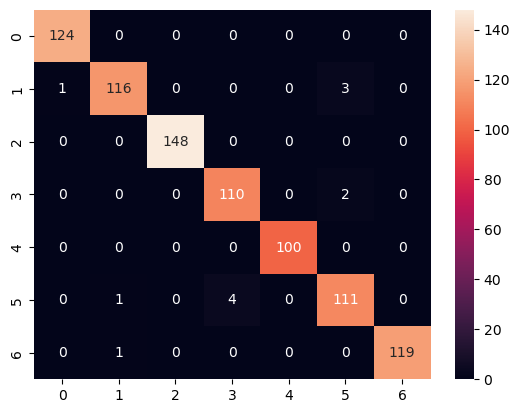

In [71]:
lr_yhat = lr_model.predict(X_test)
y_true = [np.argmax(y) for y in y_test]
cm = confusion_matrix(lr_yhat,y_true)
sns.heatmap(cm, annot=True,fmt='g')
print('Test Accuracy:',lr_model.score(X_test,np.argmax(y_test,axis=1)))

In [108]:
#Classification Report
lr_report = classification_report(y_true,lr_yhat)
print('==================Logistic Regression==================')

print(lr_report) 

==================Logistic Regression==================
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       125
           1       0.97      0.98      0.97       118
           2       1.00      1.00      1.00       148
           3       0.98      0.96      0.97       114
           4       1.00      1.00      1.00       100
           5       0.96      0.96      0.96       116
           6       0.99      1.00      1.00       119

    accuracy                           0.99       840
   macro avg       0.99      0.99      0.99       840
weighted avg       0.99      0.99      0.99       840



## Naive Bayes

In [52]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(X_train, np.argmax(y_train,axis=1))

GaussianNB()

In [53]:
nb_model.score(X_test, np.argmax(y_test, axis=1))

0.9476190476190476

Test Accuracy: 0.9476190476190476


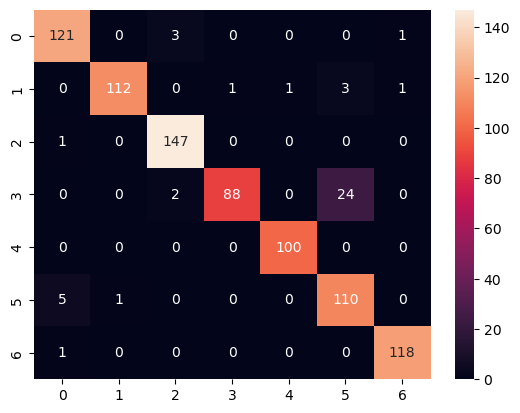

In [75]:
nb_yhat = nb_model.predict(X_test)
cm = confusion_matrix(np.argmax(y_test, axis=1),nb_yhat)
sns.heatmap(cm, annot=True,fmt='g')
nb_model.score(X_test, np.argmax(y_test, axis=1))
print('Test Accuracy:',nb_model.score(X_test, np.argmax(y_test, axis=1)))

In [110]:
nb_report = classification_report(y_true,nb_yhat)
print('======================Naive Bayes======================')

print(nb_report)

======================Naive Bayes======================
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       125
           1       0.99      0.95      0.97       118
           2       0.97      0.99      0.98       148
           3       0.99      0.77      0.87       114
           4       0.99      1.00      1.00       100
           5       0.80      0.95      0.87       116
           6       0.98      0.99      0.99       119

    accuracy                           0.95       840
   macro avg       0.95      0.95      0.95       840
weighted avg       0.95      0.95      0.95       840



## A simple Neural Network

In [56]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [35]:
X_train.shape

(1960, 40)

In [36]:
#no of classes
num_labels=y_train.shape[1]
num_labels

7

In [49]:
#Simple CNN model

model = Sequential()
model.add(Dense(100, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))


model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 100)               4100      
                                                                 
 activation_8 (Activation)   (None, 100)               0         
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 200)               20200     
                                                                 
 activation_9 (Activation)   (None, 200)               0         
                                                                 
 dropout_7 (Dropout)         (None, 200)               0         
                                                                 
 dense_10 (Dense)            (None, 100)              

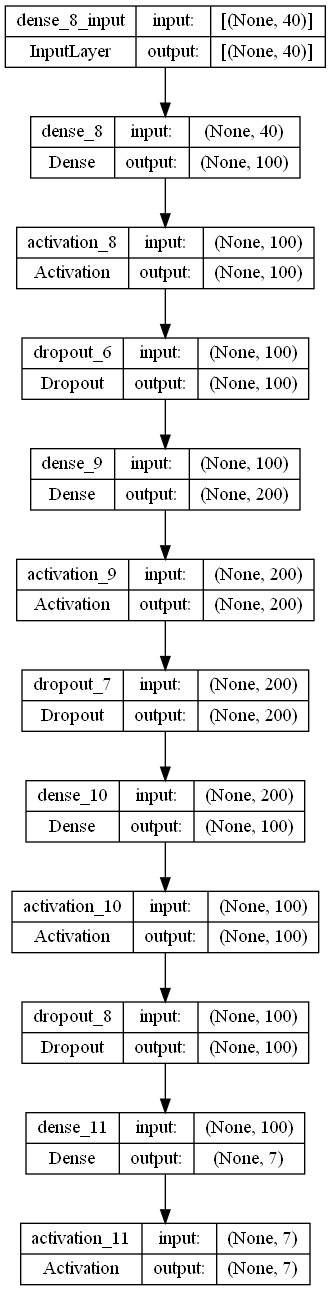

In [85]:
from tensorflow.keras.utils import plot_model
plot_model(loaded_model, to_file='model.png', show_shapes=True)

In [50]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')

In [51]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [52]:
epochs = 100
batch_size = 32
check = ModelCheckpoint(filepath='model/my_cnn.hdf5', verbose=1, save_best_only=True)


In [53]:
%%time
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,validation_split=0.3, callbacks=[check])

Epoch 1/100
30/43 [===================>..........] - ETA: 0s - loss: 1.8623 - accuracy: 0.2656
Epoch 1: val_loss improved from inf to 1.13575, saving model to model\my_cnn.hdf5
43/43 [==============================] - 1s 11ms/step - loss: 1.7641 - accuracy: 0.3090 - val_loss: 1.1358 - val_accuracy: 0.7857
Epoch 2/100
42/43 [============================>.] - ETA: 0s - loss: 1.1764 - accuracy: 0.5707
Epoch 2: val_loss improved from 1.13575 to 0.61010, saving model to model\my_cnn.hdf5
43/43 [==============================] - 0s 8ms/step - loss: 1.1697 - accuracy: 0.5736 - val_loss: 0.6101 - val_accuracy: 0.8469
Epoch 3/100
39/43 [==========================>...] - ETA: 0s - loss: 0.8220 - accuracy: 0.6851
Epoch 3: val_loss improved from 0.61010 to 0.36566, saving model to model\my_cnn.hdf5
43/43 [==============================] - 0s 6ms/step - loss: 0.8009 - accuracy: 0.6946 - val_loss: 0.3657 - val_accuracy: 0.9082
Epoch 4/100
32/43 [=====================>........] - ETA: 0s - loss: 0.61

43/43 [==============================] - 0s 5ms/step - loss: 0.0744 - accuracy: 0.9774 - val_loss: 0.0204 - val_accuracy: 0.9949
Epoch 29/100
33/43 [======================>.......] - ETA: 0s - loss: 0.0572 - accuracy: 0.9811
Epoch 29: val_loss did not improve from 0.01596
43/43 [==============================] - 0s 4ms/step - loss: 0.0541 - accuracy: 0.9825 - val_loss: 0.0201 - val_accuracy: 0.9949
Epoch 30/100
29/43 [===================>..........] - ETA: 0s - loss: 0.0414 - accuracy: 0.9881
Epoch 30: val_loss did not improve from 0.01596
43/43 [==============================] - 0s 5ms/step - loss: 0.0625 - accuracy: 0.9832 - val_loss: 0.0177 - val_accuracy: 0.9949
Epoch 31/100
32/43 [=====================>........] - ETA: 0s - loss: 0.0520 - accuracy: 0.9873
Epoch 31: val_loss did not improve from 0.01596
43/43 [==============================] - 0s 4ms/step - loss: 0.0750 - accuracy: 0.9818 - val_loss: 0.0173 - val_accuracy: 0.9949
Epoch 32/100
29/43 [===================>..........] 

39/43 [==========================>...] - ETA: 0s - loss: 0.0135 - accuracy: 0.9976
Epoch 88: val_loss did not improve from 0.01215
43/43 [==============================] - 0s 4ms/step - loss: 0.0130 - accuracy: 0.9978 - val_loss: 0.0166 - val_accuracy: 0.9932
Epoch 89/100
38/43 [=========================>....] - ETA: 0s - loss: 0.0131 - accuracy: 0.9942
Epoch 89: val_loss did not improve from 0.01215
43/43 [==============================] - 0s 4ms/step - loss: 0.0146 - accuracy: 0.9942 - val_loss: 0.0136 - val_accuracy: 0.9949
Epoch 90/100
22/43 [==============>...............] - ETA: 0s - loss: 0.0112 - accuracy: 0.9986    
Epoch 90: val_loss did not improve from 0.01215
43/43 [==============================] - 0s 4ms/step - loss: 0.0139 - accuracy: 0.9971 - val_loss: 0.0145 - val_accuracy: 0.9949
Epoch 91/100
35/43 [=======================>......] - ETA: 0s - loss: 0.0128 - accuracy: 0.9964
Epoch 91: val_loss did not improve from 0.01215
43/43 [==============================] - 0s 4m

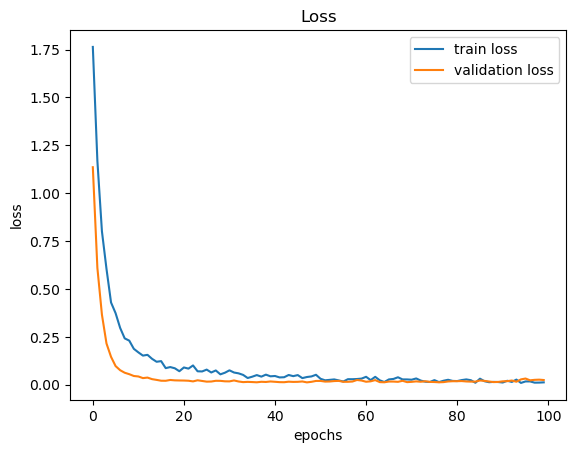

In [54]:
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

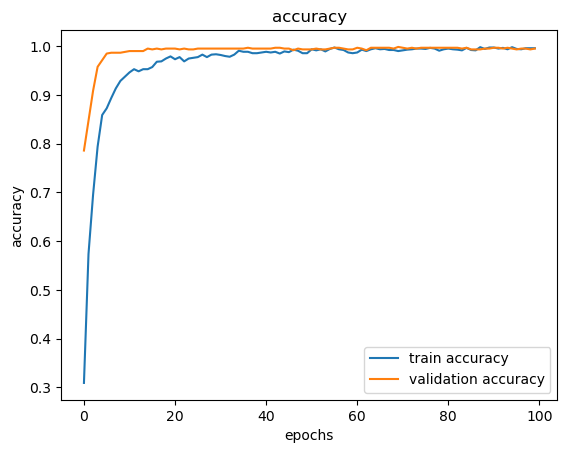

In [56]:
plt.plot(history.history['accuracy'],label='train accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

In [101]:
y_hat=model.predict(X_test)

27/27 [==============================] - 0s 2ms/step


In [90]:
y_hat=loaded_model.predict(X_test)

27/27 [==============================] - 0s 1ms/step


In [91]:
y_pred=np.argmax(y_hat,axis=1)

In [92]:
cm = confusion_matrix(y_true,y_pred)

<AxesSubplot: >

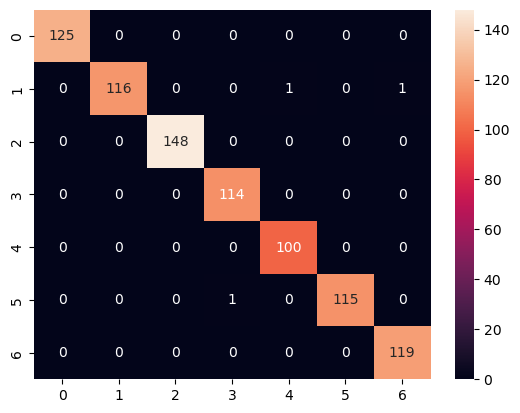

In [93]:
sns.heatmap(cm, annot=True, fmt='g')

In [105]:
acc = model.evaluate(X_test, y_test, verbose=0)
acc[1]

0.9964285492897034

In [113]:
print('==================My Sequential Model==================')
print(classification_report(y_true,y_pred))

==================My Sequential Model==================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       125
           1       1.00      0.98      0.99       118
           2       1.00      1.00      1.00       148
           3       0.99      1.00      1.00       114
           4       0.99      1.00      1.00       100
           5       1.00      0.99      1.00       116
           6       0.99      1.00      1.00       119

    accuracy                           1.00       840
   macro avg       1.00      1.00      1.00       840
weighted avg       1.00      1.00      1.00       840



## Sanity Check

In [65]:
loaded_model = tf.keras.models.load_model('model/my_cnn.hdf5')
path = 'test/'
fpath=[]
labels=[]
for dir_,_,files in os.walk(path):
    for file in files:
        fpath.append(os.path.join(dir_, file))
        labels.append(file.lower().split('_')[-1].split('.')[0])
test_df = pd.DataFrame()
test_df['fpath'] = fpath
test_df['labels'] = labels
test_df.sample(5)

,fpath,labels
4,test/OAF_boat_fear.wav,fear
10,test/YAF_bath_happy.wav,happy
0,test/OAF_bite_ps.wav,ps
13,test/YAF_beg_disgust.wav,disgust
12,test/YAF_bean_happy.wav,happy


In [58]:
test_mfccs=[]
for idx, rows in tqdm(test_df.iterrows()):
    filename = test_df.iloc[idx].fpath
    label = test_df.iloc[idx].labels
    #print(filename)
    #print(label)
    data = feature_extract(filename)
    test_mfccs.append([data,label])
test_features_df = pd.DataFrame(test_mfccs, columns=['mfcc','labels'])
test_features_df.sample(5)

15it [00:00, 26.27it/s]


,mfcc,labels
13,"[-425.0521, 72.98535, 2.6355808, 20.418978, -4...",disgust
12,"[-311.92065, 43.744675, 9.639169, 34.031673, 8...",happy
7,"[-452.5025, 118.36442, -1.6029191, 11.21225, -...",ps
6,"[-492.67145, 132.53093, 2.629666, 25.399456, -...",neutral
4,"[-443.749, 111.18818, -11.746383, 13.072679, -...",fear


In [59]:
test_X = np.array(test_features_df['mfcc'].tolist())
test_y = np.array(test_features_df['labels'].tolist())
test_X = sc.fit_transform(test_X)
test_y = np.array(pd.get_dummies(test_y))

## Neural Network result

In [68]:
test_acc = loaded_model.evaluate(test_X, test_y, verbose=0)
print('Test accuracy:',test_acc[1])

Test accuracy: 1.0


## Random Forest result

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      0.80      0.89         5
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2

    accuracy                           0.93        15
   macro avg       0.93      0.97      0.94        15
weighted avg       0.97      0.93      0.94        15



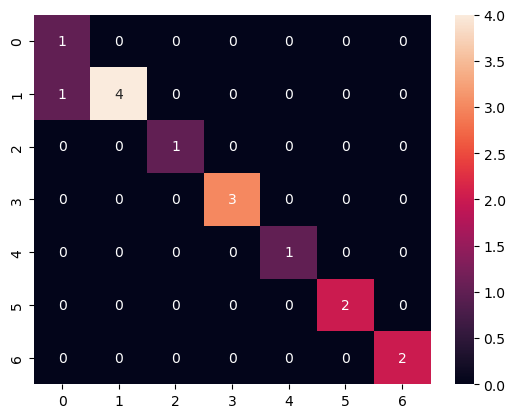

In [60]:
y_hat = rf_grid.predict(test_X)
y_pred = [np.argmax(y) for y in y_hat]
y_true = [np.argmax(y) for y in test_y]
cm = confusion_matrix(y_true,y_pred)
sns.heatmap(cm, annot=True,fmt='g')
rf_report = classification_report(y_true,y_pred)
print(rf_report)

## SVM Result

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



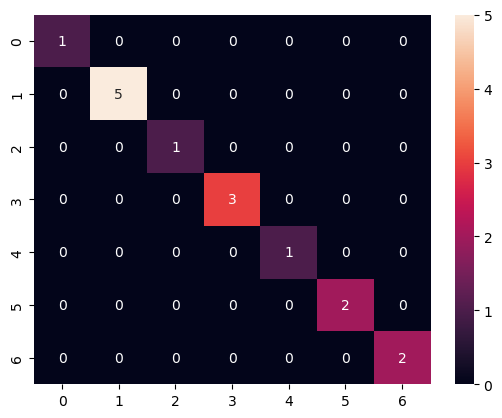

In [61]:
svm_yhat=svm_model.predict(test_X)
cm = confusion_matrix(np.argmax(test_y, axis=1),svm_yhat)
sns.heatmap(cm, annot=True,fmt='g')
svm_report = classification_report(np.argmax(test_y,axis=1),svm_yhat)
print(svm_report)

## Logistic Regression result

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         1
           3       1.00      0.67      0.80         3
           4       1.00      1.00      1.00         1
           5       0.67      1.00      0.80         2
           6       1.00      1.00      1.00         2

    accuracy                           0.93        15
   macro avg       0.95      0.95      0.94        15
weighted avg       0.96      0.93      0.93        15



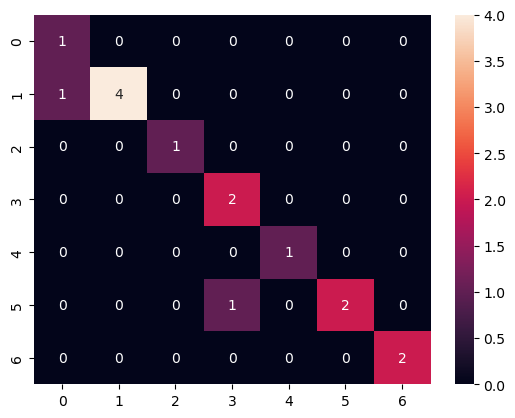

In [62]:
lr_yhat = lr_model.predict(test_X)
cm = confusion_matrix(lr_yhat,y_pred)
sns.heatmap(cm, annot=True,fmt='g')
lr_report = classification_report(np.argmax(test_y,axis=1),lr_yhat)
print(lr_report)

## Naive Bayes result

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         1
           3       1.00      0.67      0.80         3
           4       1.00      1.00      1.00         1
           5       0.67      1.00      0.80         2
           6       1.00      1.00      1.00         2

    accuracy                           0.93        15
   macro avg       0.95      0.95      0.94        15
weighted avg       0.96      0.93      0.93        15



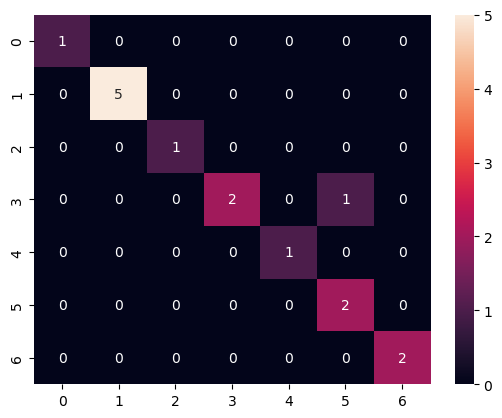

In [63]:
nb_yhat = nb_model.predict(test_X)
cm = confusion_matrix(np.argmax(test_y, axis=1),nb_yhat)
sns.heatmap(cm, annot=True,fmt='g')
nb_report = classification_report(np.argmax(test_y,axis=1),nb_yhat)
print(nb_report)